# Imports

In [1]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shap
from joblib import dump, load

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

## Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

## Metrics
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (auc,roc_auc_score, ConfusionMatrixDisplay, 
                             precision_score, PrecisionRecallDisplay,
                             recall_score, roc_curve,RocCurveDisplay, f1_score,
                             accuracy_score, classification_report)

# Functions

In [2]:
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
  ## Get the classification report
  report = classification_report(y_true, y_pred)
    
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
    
  ## Confusion matrices subplots
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
  ## Confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0]);
  axes[0].set_title("Raw Counts")
  
  ## Confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")

  ## Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  
  ## Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [3]:
def multiclass_roc_auc_score(model, X_test, y_test, num_classes):
    # Binarize the output labels
    y_binarized = label_binarize(y_test, classes=[*range(num_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_prob = model.predict_proba(X_test)
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Plotting each class's ROC curve (optional)
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for class {i}')
        plt.legend(loc="lower right")
        plt.show()

    # Calculate the average ROC AUC score
    average_roc_auc = np.mean(list(roc_auc.values()))
    print(f"Average ROC AUC score: {average_roc_auc}")

    return roc_auc, average_roc_auc

In [4]:
def evaluate_classification(model, X_train, y_train, X_test, y_test, num_classes=3,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    ## Get predictions & probability for training data
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)
    
    ## Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    ## Get predictions & probability for test data
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)
    
    ## Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data')
    
    ## Visualize the ROC curve
    multiclass_roc_auc_score(model, X_test, y_test, num_classes)
    
    
    if output_dict == True:
        ## Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

# Load Data

In [5]:
## Load unprocessed data to avoid data leakage
df = pd.read_csv('Data/fall_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Distance       2039 non-null   float64
 1   Pressure       2039 non-null   float64
 2   HRV            2039 non-null   float64
 3   Sugar level    2039 non-null   float64
 4   SpO2           2039 non-null   float64
 5   Accelerometer  2039 non-null   float64
 6   Decision       2039 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 111.6 KB


Distance  Pressure      HRV  Sugar level    SpO2  Accelerometer  Decision 
0    25.540       1.0  101.396       61.080  87.770            1.0          1
1     2.595       2.0  110.190       20.207  65.190            1.0          2
2    68.067       0.0   87.412       79.345  99.345            0.0          0
3    13.090       1.0   92.266       36.180  81.545            1.0          1
4    69.430       0.0   89.480       80.000  99.990            0.0          0

In [6]:
## Format column headers to lowercase
df.columns = df.columns.str.lower()
df.head()

distance  pressure      hrv  sugar level    spo2  accelerometer  decision 
0    25.540       1.0  101.396       61.080  87.770            1.0          1
1     2.595       2.0  110.190       20.207  65.190            1.0          2
2    68.067       0.0   87.412       79.345  99.345            0.0          0
3    13.090       1.0   92.266       36.180  81.545            1.0          1
4    69.430       0.0   89.480       80.000  99.990            0.0          0

In [7]:
df.columns

Index(['distance', 'pressure', 'hrv', 'sugar level', 'spo2', 'accelerometer',
       'decision '],
      dtype='object')

In [8]:
## Reformat column names
df.rename(columns={'distance':'distance (cm)','hrv':'hrv (bpm)',
                   'sugar level':'blood sugar level (mg/dL)',
                   'decision ':'decision',}, inplace=True)
df.head()

distance (cm)  pressure  hrv (bpm)  blood sugar level (mg/dL)    spo2  \
0         25.540       1.0    101.396                     61.080  87.770   
1          2.595       2.0    110.190                     20.207  65.190   
2         68.067       0.0     87.412                     79.345  99.345   
3         13.090       1.0     92.266                     36.180  81.545   
4         69.430       0.0     89.480                     80.000  99.990   

   accelerometer  decision  
0            1.0         1  
1            1.0         2  
2            0.0         0  
3            1.0         1  
4            0.0         0

In [9]:
df.describe()

distance (cm)     pressure    hrv (bpm)  blood sugar level (mg/dL)  \
count    2039.000000  2039.000000  2039.000000                2039.000000   
mean       28.694527     0.988720    95.657002                  72.909243   
std        23.773644     0.815918    17.576499                  46.940110   
min         0.000000     0.000000    60.000000                  10.000000   
25%         7.642500     0.000000    82.418000                  40.230000   
50%        20.560000     1.000000    97.238000                  69.960000   
75%        55.205500     2.000000   109.695000                  77.612500   
max        69.981000     2.000000   124.980000                 179.293000   

              spo2  accelerometer     decision  
count  2039.000000    2039.000000  2039.000000  
mean     83.563649       0.661599     0.988720  
std      11.111592       0.473282     0.815918  
min      60.000000       0.000000     0.000000  
25%      75.285000       0.000000     0.000000  
50%      85.280000       1.000000     1.000000  
75%      92.692500       1.000000     2.000000  
max      99.990000       1.000000     2.000000

In [10]:
## Generating varied data
new_data = {
    'distance (cm)':np.random.uniform(0,70,size=700),
    'pressure':np.random.randint(0,3,size=700),
    'hrv (bpm)':np.random.randint(60,125,size=700),
    'blood sugar level (mg/dL)':np.random.uniform(10,180,size=700),
    'spo2':np.random.uniform(60,100,size=700),
    'accelerometer':np.random.randint(0,2,size=700),
    'decision':np.random.randint(0,3,size=700)
}

new_data = pd.DataFrame(new_data)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   distance (cm)              700 non-null    float64
 1   pressure                   700 non-null    int32  
 2   hrv (bpm)                  700 non-null    int32  
 3   blood sugar level (mg/dL)  700 non-null    float64
 4   spo2                       700 non-null    float64
 5   accelerometer              700 non-null    int32  
 6   decision                   700 non-null    int32  
dtypes: float64(3), int32(4)
memory usage: 27.5 KB


In [11]:
new_data.head()

distance (cm)  pressure  hrv (bpm)  blood sugar level (mg/dL)       spo2  \
0      53.730450         0         93                 172.668686  77.443554   
1      66.096881         0        106                  85.995039  75.836512   
2      68.504250         2        117                 156.313614  92.651402   
3      63.544792         2         73                 171.658315  97.268575   
4      37.452611         2         98                 123.158988  73.279461   

   accelerometer  decision  
0              0         2  
1              1         1  
2              1         0  
3              0         1  
4              0         0

In [12]:
new_data['pressure'].value_counts()

0    240
2    235
1    225
Name: pressure, dtype: int64

In [13]:
df = pd.concat([df,new_data], ignore_index=True)

In [14]:
# Specify the range of indices to remove (from 0 to 700 inclusive)
indices_to_remove = range(701)  # This generates indices from 0 to 700

# Remove the rows by dropping them
df= df.drop(indices_to_remove)

df.reset_index(drop=True)

distance (cm)  pressure  hrv (bpm)  blood sugar level (mg/dL)  \
0         50.551000       0.0     60.836                  70.285000   
1          6.105000       2.0    117.210                 164.012000   
2         14.290000       1.0     93.146                  38.580000   
3          1.515000       2.0    108.030                  15.959000   
4         17.590000       1.0     95.566                  45.180000   
...             ...       ...        ...                        ...   
2033      10.722240       1.0    113.000                  31.824218   
2034      13.699170       2.0     75.000                  41.829929   
2035      59.640482       2.0    100.000                 177.751020   
2036      18.225103       0.0     96.000                  67.220325   
2037      27.708361       0.0     97.000                 142.011064   

           spo2  accelerometer  decision  
0     90.285000            0.0         0  
1     72.210000            1.0         2  
2     82.145000            1.0         1  
3     63.030000            1.0         2  
4     83.795000            1.0         1  
...         ...            ...       ...  
2033  93.439284            1.0         2  
2034  70.256564            1.0         0  
2035  71.142604            1.0         1  
2036  77.569937            1.0         1  
2037  63.106109            0.0         2  

[2038 rows x 7 columns]

In [15]:
## Determine class balance in the target
df['decision'].value_counts(normalize=True)

0    0.341511
2    0.331207
1    0.327282
Name: decision, dtype: float64

> The class balance is pretty evenly split so we will not need to re-balance classes. 

In [16]:
## Save ML dataframe
df.to_csv('Data/ml_df.csv')

# Model Validation & Preprocessing

## Train Test Split

In [17]:
## Train test split
X = df.drop(columns=['decision'])
y = df['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
## Print length of train and test splits
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

Length of X_train: 1528
Length of X_test: 510


## Preprocessing Pipeline

In [19]:
## Column Transformers
scaler = StandardScaler()

## Column selectors
num_col = make_column_selector(dtype_include='number')

## Tuples for pipeline
num_tuple = (scaler, num_col)

## Preprocessor object
prepocessor = make_column_transformer(num_tuple, verbose_feature_names_out=False)
prepocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                  verbose_feature_names_out=False)

# Baseline Models

## Decision Tree

In [20]:
## Instantiate and fit random forest model
tree = DecisionTreeClassifier()
tree_pipe = make_pipeline(prepocessor, tree)

tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       513

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



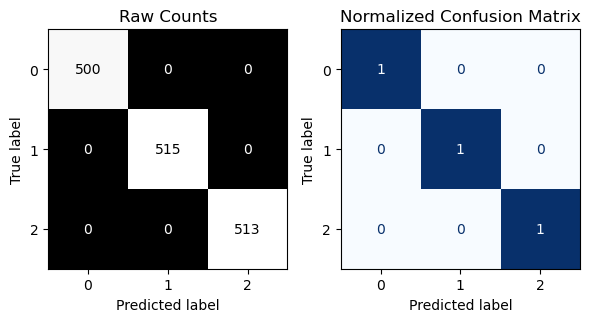


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       196
           1       0.78      0.72      0.75       152
           2       0.73      0.72      0.73       162

    accuracy                           0.75       510
   macro avg       0.75      0.75      0.75       510
weighted avg       0.75      0.75      0.75       510



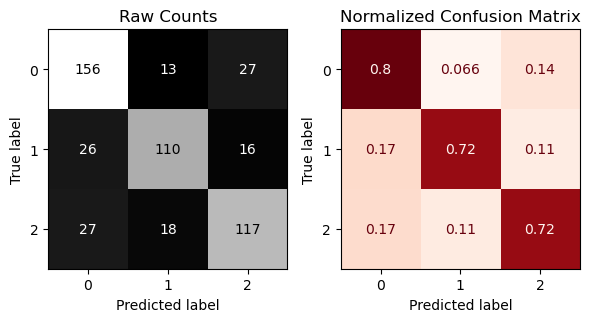

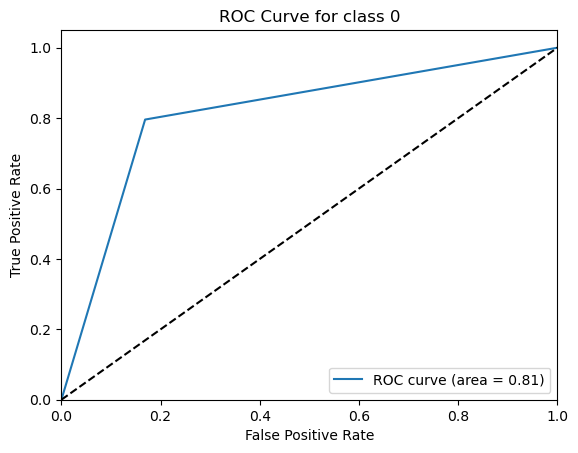

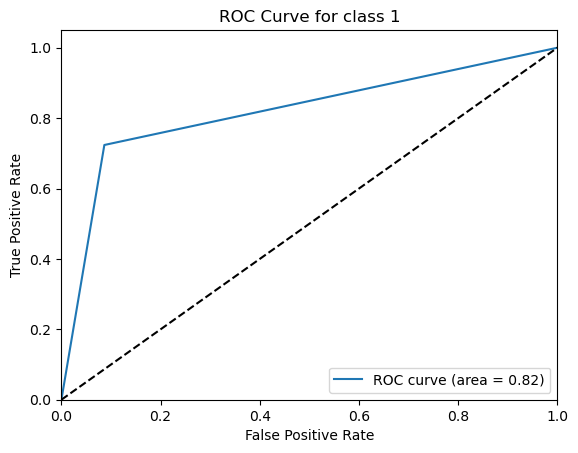

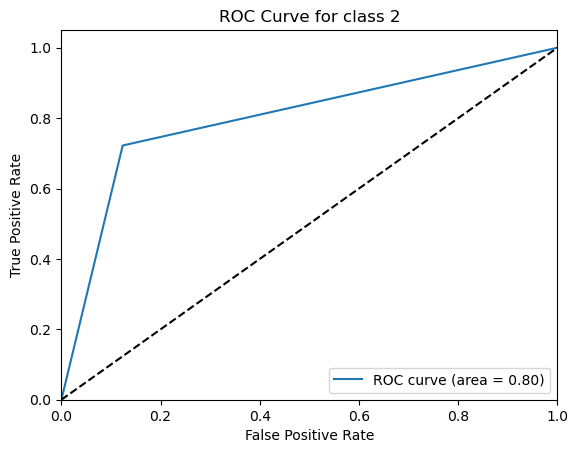

Average ROC AUC score: 0.8104799323360875


In [21]:
evaluate_classification(tree_pipe, X_train, y_train, X_test, y_test, num_classes=3,
                        figsize=(6,4), normalize='true', output_dict = False,
                        cmap_train='Blues', cmap_test="Reds",colorbar=False)

## Random Forest

In [22]:
## Instantiate and fit random forest model
rf = RandomForestClassifier()
rf_pipe = make_pipeline(prepocessor, rf)

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier', RandomForestClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       513

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



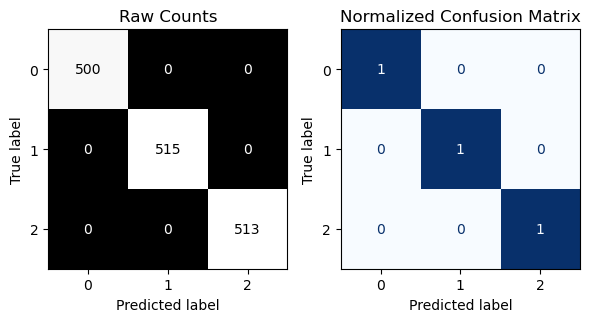


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       196
           1       0.74      0.72      0.73       152
           2       0.72      0.75      0.74       162

    accuracy                           0.76       510
   macro avg       0.76      0.76      0.76       510
weighted avg       0.76      0.76      0.76       510



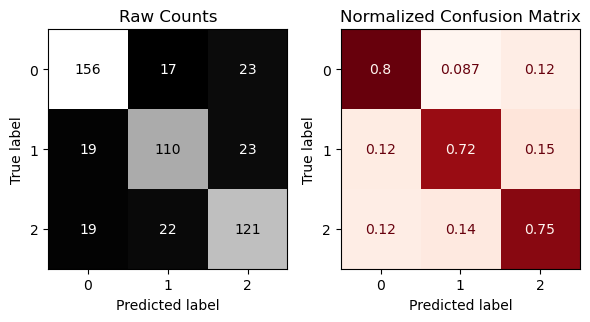

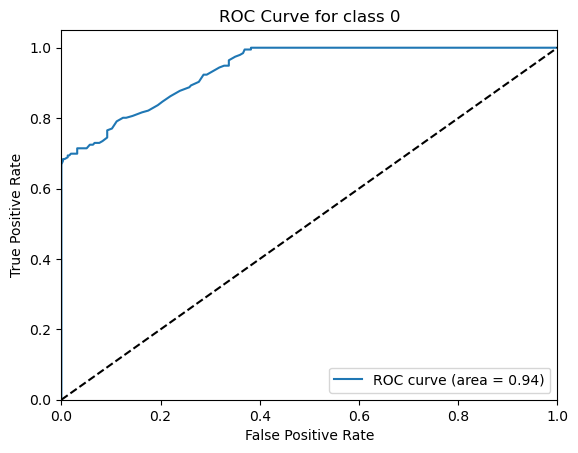

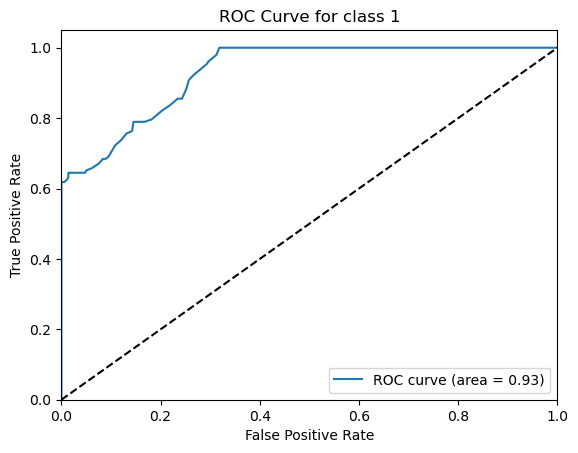

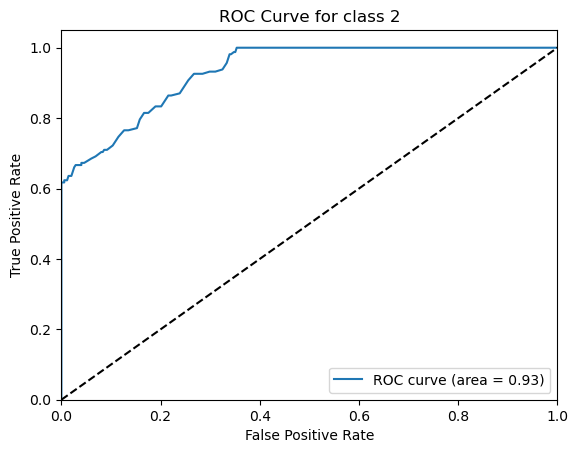

Average ROC AUC score: 0.9339551148790318


In [23]:
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

## LightGBM

In [24]:
## Instantiate and fit lightgbm model 
lgb = LGBMClassifier()
lgb_pipe = make_pipeline(prepocessor, lgb)

lgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                                   verbose_feature_names_out=False)),
                ('lgbmclassifier', LGBMClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       513

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



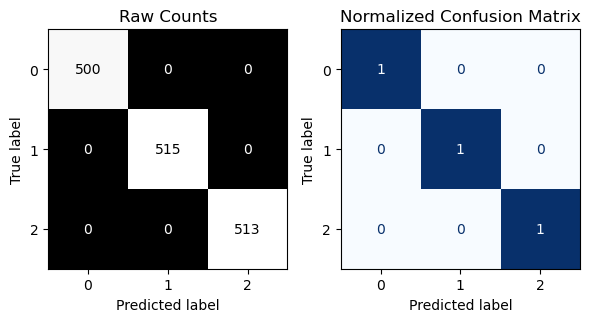


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       196
           1       0.77      0.70      0.73       152
           2       0.72      0.77      0.75       162

    accuracy                           0.76       510
   macro avg       0.76      0.75      0.75       510
weighted avg       0.76      0.76      0.76       510



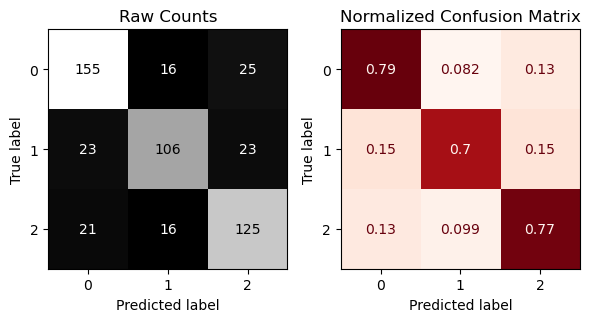

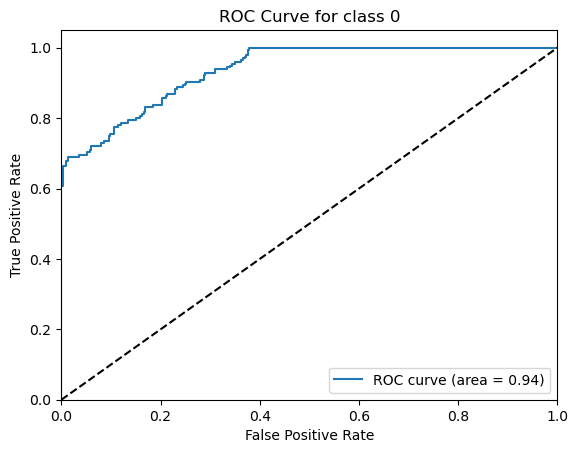

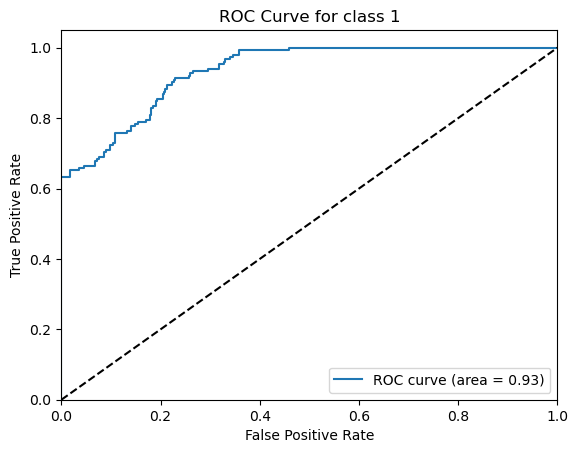

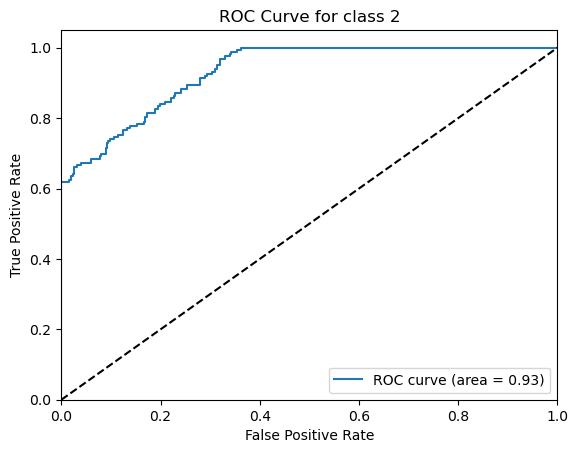

Average ROC AUC score: 0.9335678951536163


In [25]:
evaluate_classification(lgb_pipe, X_train, y_train, X_test, y_test)

# Hyperparameter Tuning with GridSearch CV

## Decision Tree

In [26]:
## Get model parameters
tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                     verbose_feature_names_out=False)),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                   verbose_feature_names_out=False),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('standardscaler',
   StandardScaler(),
   <sklearn.compose._column_transformer.make_colu

In [27]:
## Parameters to be tested
param_grid = {'decisiontreeclassifier__class_weight': [None, 'balanced'],
              'decisiontreeclassifier__max_depth': [None, 10, 100, 1000],
              'decisiontreeclassifier__max_leaf_nodes': [None, 10, 100, 1000]} 

In [28]:
## Fit and evaluate
tree_gs = GridSearchCV(tree_pipe, param_grid, verbose=2)
tree_gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=10; total time=   0.0s
[CV]

[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclass

[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=10; total time=   0.0s
[CV] END decisiontreeclassifier__class_wei

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                                                          verbose_feature_names_out=False)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__class_weight': [None,
                                                                  'balanced'],
                         'decisiontreeclassifier__max_depth': [None, 10, 100,
                                                               1000],
                         'decisiontreeclassifier__max_leaf_nodes': [None, 10,
                                                                    100,
                                                                    1000]},
             verbose=2)

In [29]:
tree_gs.best_params_

{'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_leaf_nodes': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       513

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



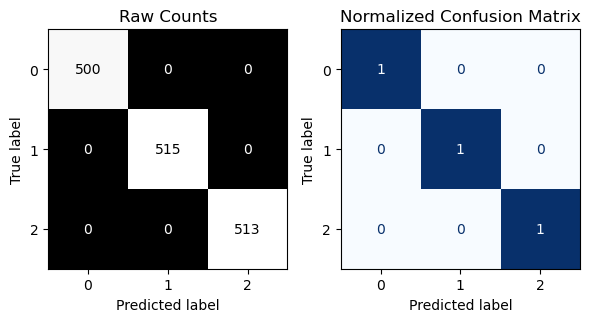


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.81      0.78       196
           1       0.78      0.73      0.76       152
           2       0.77      0.73      0.75       162

    accuracy                           0.76       510
   macro avg       0.76      0.76      0.76       510
weighted avg       0.76      0.76      0.76       510



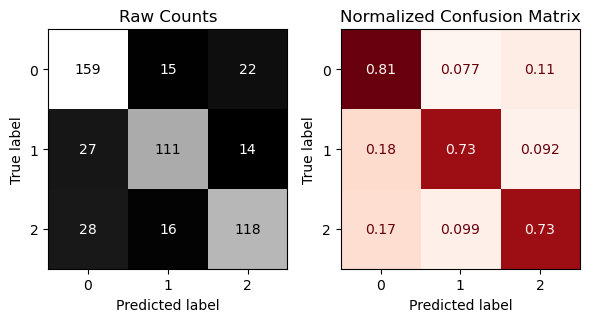

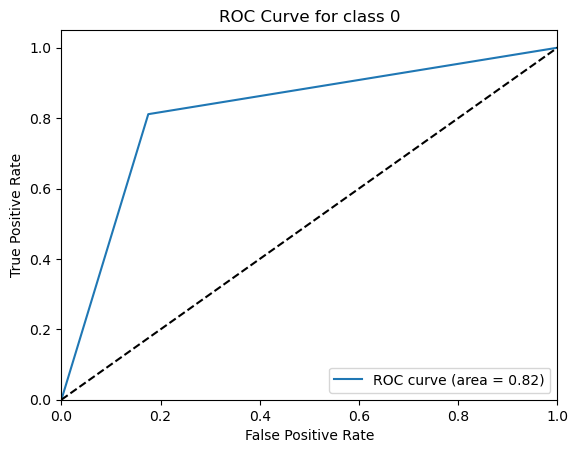

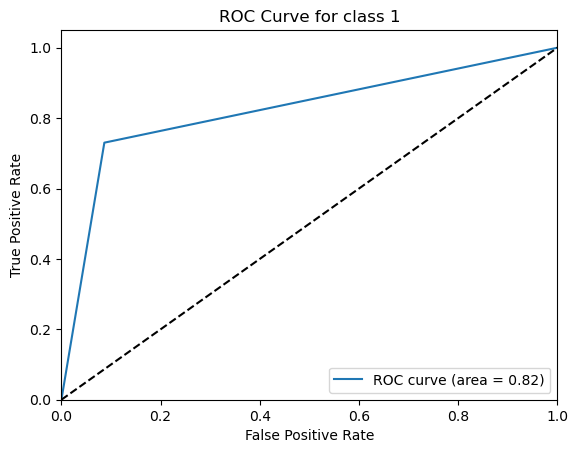

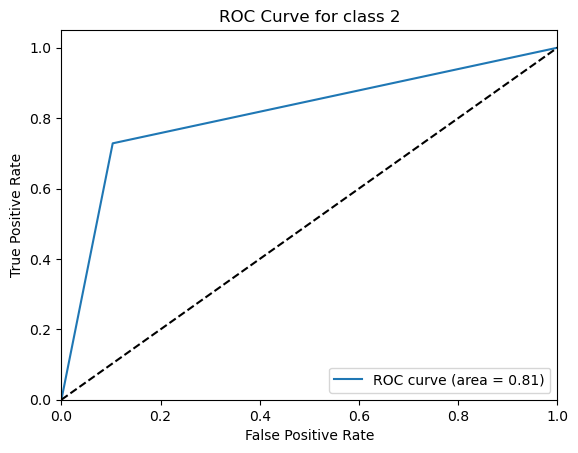

Average ROC AUC score: 0.8174471698528736


In [30]:
## Fit best estimator
best_tree_gs = tree_gs.best_estimator_
best_tree_gs.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(best_tree_gs, X_train, y_train, X_test, y_test)

## Random Forest

In [31]:
## Get model parameters
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                     verbose_feature_names_out=False)),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                   verbose_feature_names_out=False),
 'randomforestclassifier': RandomForestClassifier(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('standardscaler',
   StandardScaler(),
   <sklearn.compose._column_transformer.make_colu

In [32]:
## Parameters to be tested
param_grid = {'randomforestclassifier__class_weight': ['balanced'],
              'randomforestclassifier__max_depth': [10, 100, 1000],
              'randomforestclassifier__max_leaf_nodes': [10, 100, 1000],
              'randomforestclassifier__n_estimators': [10, 100]} 

In [33]:
## Fit and evaluate
rf_gs = GridSearchCV(rf_pipe, param_grid, verbose=2)
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestcl

[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s


[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.0s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2063C7F0>)],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__class_weight': ['balanced'],
                         'randomforestclassifier__max_depth': [10, 100, 1000],
                         'randomforestclassifier__max_leaf_nodes': [10, 100,
                                                                    1000],
                         'randomforestclassifier__n_estimators': [10, 100]},
             verbose=2)

In [34]:
rf_gs.best_params_

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_leaf_nodes': 1000,
 'randomforestclassifier__n_estimators': 10}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.98      0.98      0.98       515
           2       0.99      0.99      0.99       513

    accuracy                           0.98      1528
   macro avg       0.98      0.98      0.98      1528
weighted avg       0.98      0.98      0.98      1528



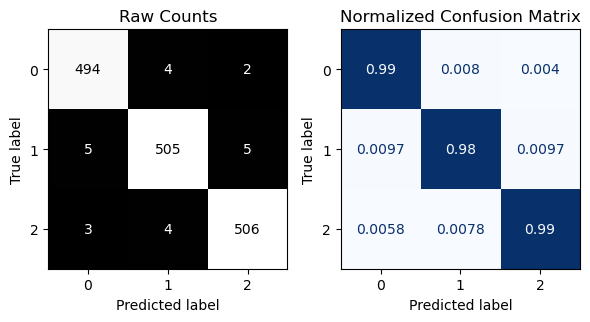


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       196
           1       0.74      0.75      0.74       152
           2       0.70      0.73      0.71       162

    accuracy                           0.76       510
   macro avg       0.76      0.76      0.76       510
weighted avg       0.76      0.76      0.76       510



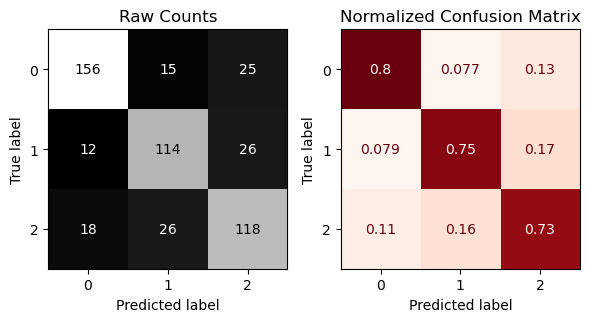

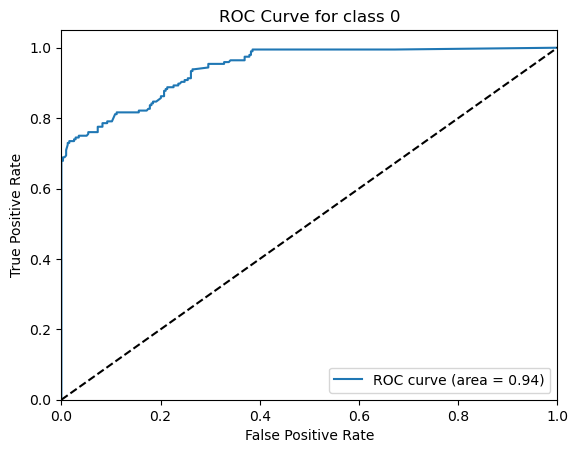

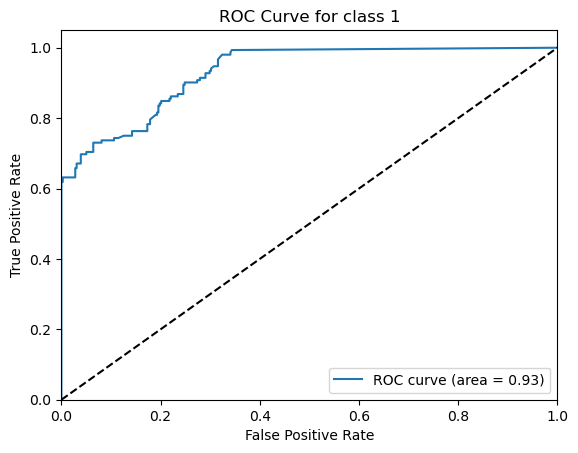

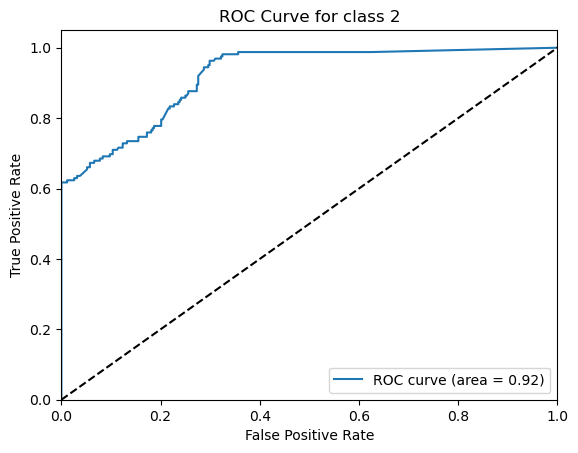

Average ROC AUC score: 0.9310270942192393


In [35]:
## Fit best estimator
best_rf_gs = rf_gs.best_estimator_
best_rf_gs.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(best_rf_gs, X_train, y_train, X_test, y_test)

In [36]:
best_rf_gs

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF224C79A0>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_leaf_nodes=1000,
                                        n_estimators=10))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       513

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



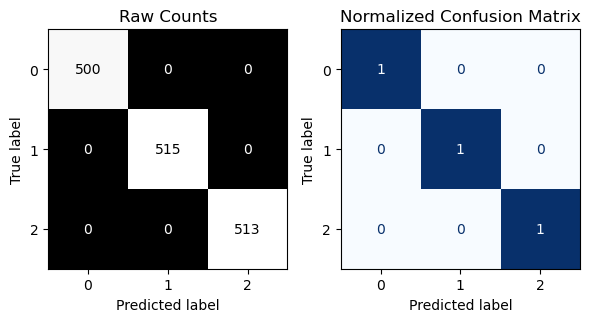


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       196
           1       0.73      0.71      0.72       152
           2       0.75      0.78      0.76       162

    accuracy                           0.76       510
   macro avg       0.76      0.76      0.76       510
weighted avg       0.76      0.76      0.76       510



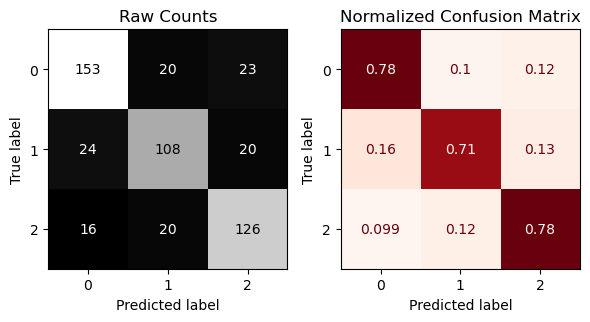

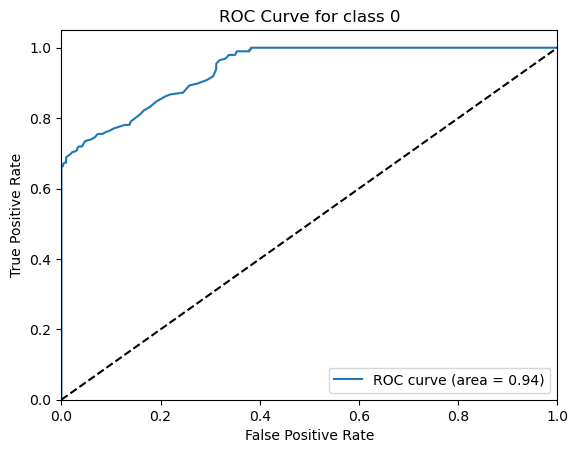

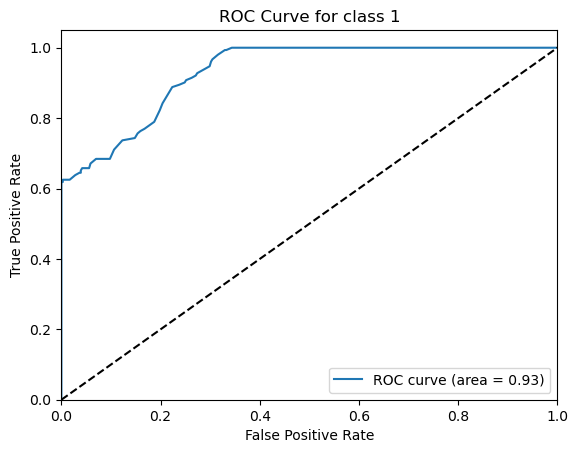

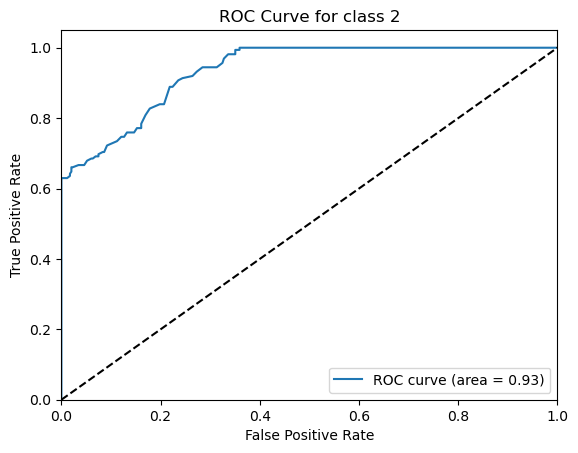

Average ROC AUC score: 0.9347960004700294


In [37]:
## Instantiate and fit random forest model
rf = RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=100)
rf_pipe = make_pipeline(prepocessor, rf)

rf_pipe.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

# Final Model Explanation

In [38]:
# Access the RandomForestClassifier from the pipeline
rf_classifier = best_rf_gs.named_steps['randomforestclassifier']

# Extract feature importances
feature_names = rf_pipe[:-1].get_feature_names_out()  # Getting feature names correctly from the pipeline
feature_importance = pd.Series(rf_classifier.feature_importances_, index=feature_names)

# Create a DataFrame from the series for easier handling with Plotly
feature_importance_df = pd.DataFrame({'Feature': feature_importance.index, 'Importance': feature_importance.values})

# Sort the DataFrame by importance
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Visualize using Plotly Express - showing all features or just top 4 if needed
fig = px.bar(sorted_feature_importance_df, x='Importance', y='Feature', orientation='h', 
             title='Average Feature Importances')
fig.update_layout(xaxis_title='Feature Importance Value', yaxis_title='Feature Name')

# Show the plot
fig.show()

In [39]:
feature_names = X_train.columns

# Transform the test set
X_test_df = pd.DataFrame(rf_pipe[:-1].transform(X_test),
                         columns=feature_names,
                         index=X_test.index)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test_df)

# Since we have 3 classes, shap_values will be a list of 3 arrays: one for each class
for i in range(3):  # Assuming three classes
    shap_df = pd.DataFrame(shap_values[i], columns=feature_names)
    
    # Summarize SHAP values per feature (mean absolute value for simplicity)
    shap_summary = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Value (mean abs)': shap_df.abs().mean().values
    })
    
    # Sort the DataFrame by SHAP values in descending order
    shap_summary_sorted = shap_summary.sort_values(by='SHAP Value (mean abs)', ascending=True)
    
    # Plot using Plotly Express
    fig = px.bar(shap_summary_sorted, x='SHAP Value (mean abs)', y='Feature',
                 orientation='h', title=f"Mean Absolute SHAP Values for Class {i}",
                 labels={'SHAP Value (mean abs)': 'Mean Absolute SHAP Value'},
                 color='SHAP Value (mean abs)',
                 color_continuous_scale=px.colors.diverging.Tealrose,
                 template='plotly_white')

    fig.show()

In [40]:
feature_names = X_train.columns

# Transform the test set
X_test_df = pd.DataFrame(rf_pipe[:-1].transform(X_test),
                         columns=feature_names,
                         index=X_test.index)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test_df)

if isinstance(shap_values, list):
    shap_values_for_class = shap_values[2]  # Adjust the index if a different class is of interest
else:
    shap_values_for_class = shap_values

# Get the SHAP values for the first prediction
shap_values_first_prediction = shap_values_for_class[0]

# Find the index of the feature with the highest absolute SHAP value
most_important_feature_index = np.argmax(np.abs(shap_values_first_prediction))

# Get the name of the most important feature
most_important_feature_name = feature_names[most_important_feature_index]

# Optionally, you can print or return this information
print(f"The most important feature for the first prediction is {most_important_feature_name} with a SHAP value of {shap_values_first_prediction[most_important_feature_index]}")


The most important feature for the first prediction is distance (cm) with a SHAP value of -0.09962052630416801


In [41]:
# Feature names extracted from the training set
feature_names = X_train.columns

# Transform the test set
X_test_df = pd.DataFrame(rf_pipe[:-1].transform(X_test),
                         columns=feature_names,
                         index=X_test.index)

# Access the RandomForestClassifier from the pipeline
rf_classifier = rf_pipe.named_steps['randomforestclassifier']

# Transform the test set
X_test_df = pd.DataFrame(rf_pipe[:-1].transform(X_test),
                         columns=feature_names,
                         index=X_test.index)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test_df)

# Choose an instance to analyze
instance_index = 0  # Change as needed

# Determine the most important feature for each class
important_features = {}
for class_index in range(3):  # Assuming there are 3 classes
    class_shap_values = shap_values[class_index][instance_index]
    most_important_feature_index = np.argmax(np.abs(class_shap_values))
    most_important_feature = X_test.columns[most_important_feature_index]
    important_features[f'Class {class_index}'] = most_important_feature

print("Most important features for each class:")
for class_label, feature in important_features.items():
    print(f"{class_label}: {feature}")


Most important features for each class:
Class 0: distance (cm)
Class 1: spo2
Class 2: distance (cm)


In [42]:
best_rf_gs

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF224C79A0>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_leaf_nodes=1000,
                                        n_estimators=10))])

In [43]:
## Saving model pipeline to joblib file
dump(best_rf_gs, 'rf.joblib')

['rf.joblib']

In [44]:
## Confirm model saved correctly
model= load('rf.joblib')

In [45]:
def predict_label(features_df):
    
    ## Load saved model
    model = load('rf.joblib')

    # Make a prediction with the trained model
    prediction_label = model.predict(features_df)
    
    
    # Return prediction labels and confidence scores
    return prediction_label

In [46]:
predict_label(df)

array([0, 2, 1, ..., 1, 2, 2], dtype=int64)

In [47]:
for name, step in model.named_steps.items():
    print(f"Step name: {name} - Estimator type: {type(step).__name__}")

Step name: columntransformer - Estimator type: ColumnTransformer
Step name: randomforestclassifier - Estimator type: RandomForestClassifier


In [48]:
print(model)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CF2299B970>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_leaf_nodes=1000,
                                        n_estimators=10))])
